In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from skimage.io import imread
import lib
np.random.seed(666)

In [2]:
rootfolder = '..'

Define the function to compute the kernel given the weights and the degree of the polynomial

In [3]:
def compute_2D_LPA_kernel(w, N):
    # compute the 2D LPA kernel for a given weights and polynomial degree
    # input:
    #   w: matrix containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel

    
    # window size is the lenght of the weight vector
    r, c = w.shape
    M = r*c
    
    # create the matrix T
    tx = np.linspace(0, 1, c)
    ty = np.linspace(0, 1, r)
    tx, ty = np.meshgrid(tx, ty)
    tx = tx.reshape(-1)
    ty = ty.reshape(-1)
    T = np.zeros((M,(N+1)**2))
    cnt = 0
    for i in range(N+1):
        for j in range(N-i+1):
            if i==0 and j==0:
                T[:, cnt] = np.ones(M)
            else:
                T[:, cnt] = tx**i * ty**j
            cnt = cnt + 1
    T = T[:, :cnt]

    # unroll the matrix of the weights    
    w = w.reshape(-1)
    Q, _ = np.linalg.qr(np.diag(w) @ T)
    g_bar = ((Q @ Q[M // 2]) * w / w[M // 2]).reshape(r, c)
    g = np.flipud(np.fliplr(g_bar))

    return g

Load the image and add the noise

In [4]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

sigma_noise = 20/255
noisy_img = img + np.random.normal(size=img.shape) * sigma_noise

psnr_noisy = lib.psnr(img, noisy_img)

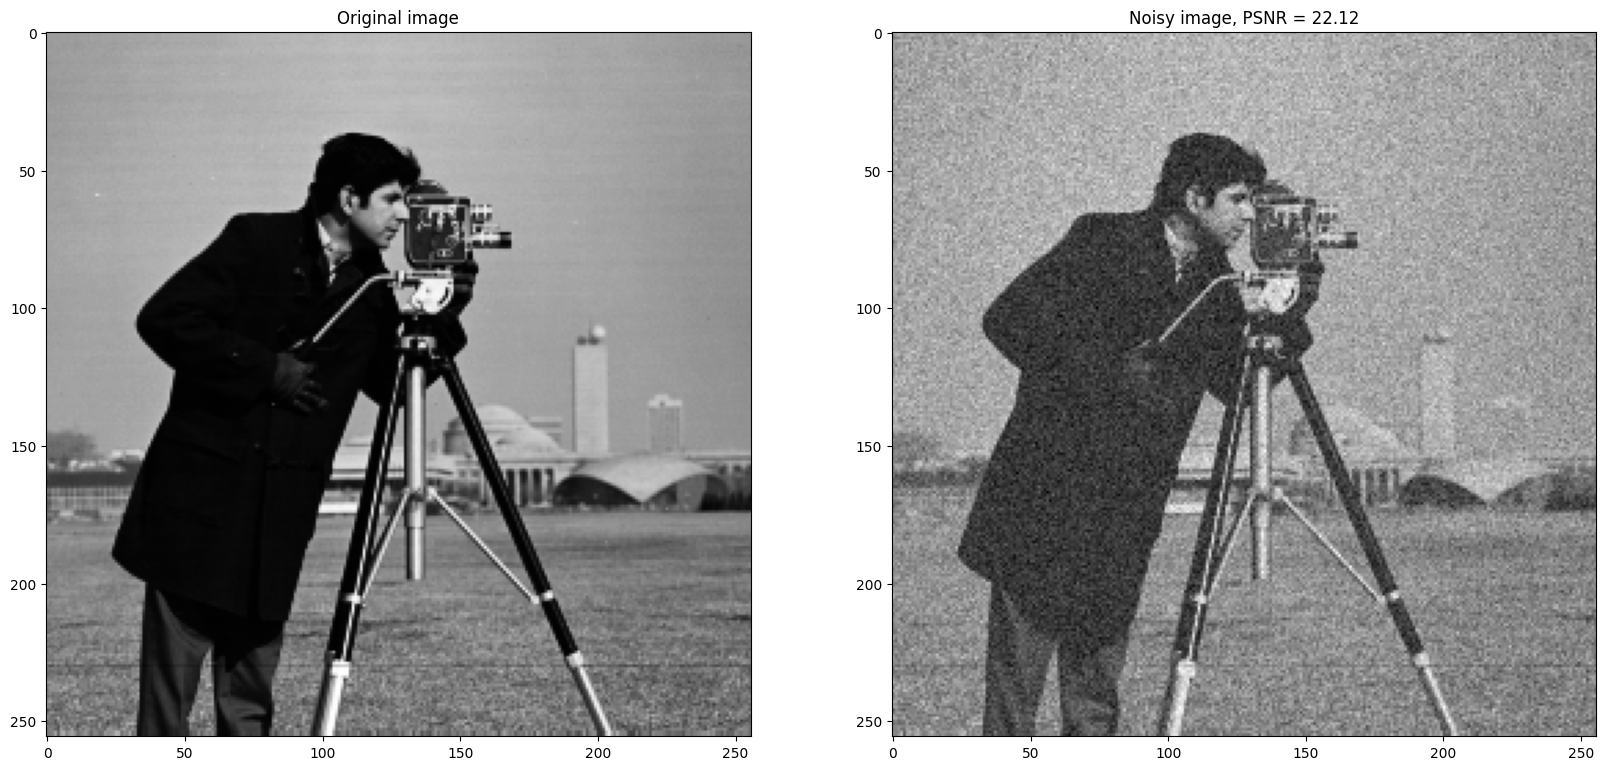

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}');

LPA-ICI 2D
----------
Set the LPA-ICI parameters

In [6]:
# maximum degree of polynomial used for fitting
N = 5

# parameter for the confidence intervals in the ICI rule
Gamma = 0.3

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

Generate the LPA kernels for all the scale. Use centered weights.


In [7]:
all_g = []
for i, h in enumerate(all_h):
        # define the weights for the scale h symmetric
        M = 2 * h - 1
        if M == 1:
                w = np.array([[1]])
        elif M == 3:
                w = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
        else:
                w = np.zeros((M, M))
                HFS = (int)((M - 1) / 2)
                HFS2 = (int)(HFS / 2)
                w[HFS2:-HFS2, HFS2:-HFS2] = 1
        # size of the weight MATRIX
        w = w / np.sum(w)
        # compute and store the kernel g
        g = compute_2D_LPA_kernel(w, N)
        all_g.append(g)

Initialize all the variables for the ICI rule

In [8]:
# initialize the estimate for each scale
yhat = np.zeros((img.shape))

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(shape=yhat.shape)

# initialize the lower and upper bound matrices
lower_bounds = - np.inf * np.ones(shape=yhat.shape)
upper_bounds = np.inf * np.ones(shape=yhat.shape) 

Loop over all the scales

In [9]:
estimated = np.zeros(shape=yhat.shape, dtype=bool)
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat_h = convolve2d(noisy_img, g, mode='same', boundary='wrap') 

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma_noise
    ub = yhat_h + Gamma * sigma_noise

    # update the lower and upper bounds
    lower_bounds[~estimated] = np.maximum(lower_bounds[~estimated], lb[~estimated])
    upper_bounds[~estimated] = np.minimum(upper_bounds[~estimated], ub[~estimated])

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    # update best_scale
    best_scale[~estimated] = h

    # update the estimate
    # update yhat
    yhat[~estimated] = yhat_h[~estimated]

    estimated = lower_bounds >= upper_bounds

Compute the PSNR

In [10]:
psnr = lib.psnr(img, yhat)

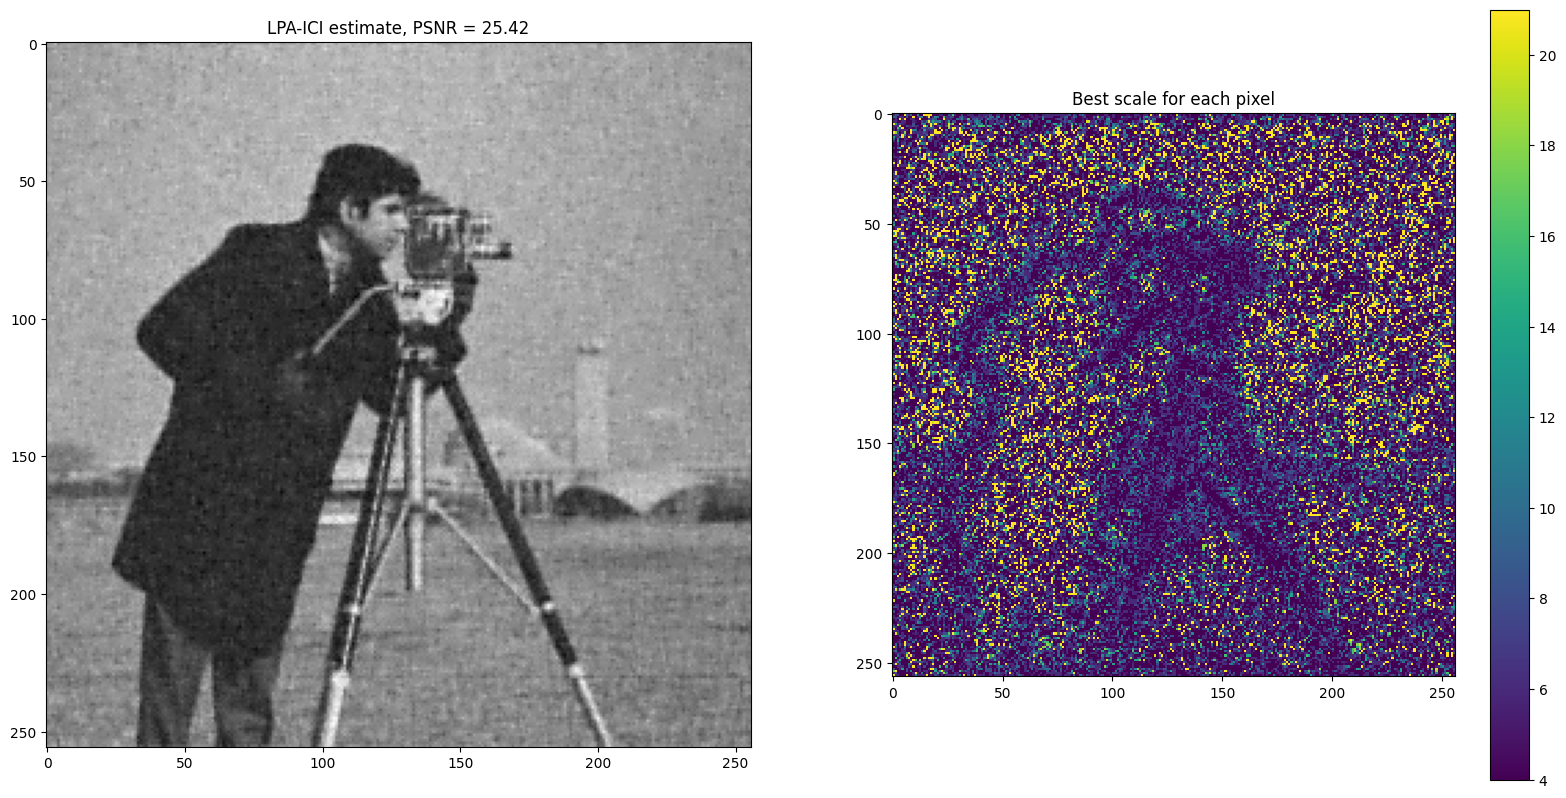

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(yhat, cmap='gray')
ax[0].set_title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')

ax[1].imshow(best_scale)
ax[1].set_title('Best scale for each pixel')
fig.colorbar(ax[1].pcolormesh(best_scale), ax=ax[1]);

Anisotropic LPA-ICI
------------------------
Set the parameters


In [12]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 0.37

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

# set all the direction values
all_theta = np.arange(4)

Generate the LPA kernels for all the scales and all the directions

In [13]:
def create_weights(M, type: str):
    w = np.zeros(M)
    HFS = int((M-1)/2)
    if type == 'center':
        w[int(HFS/2):-int(HFS/2)] = 1 # center
    if type == 'left':
        w[:HFS+1] = 1 # left
    if type == 'right':
        w[-HFS-1:] = 1 # right
    return w

In [14]:
all_g = []

types = [
    ('left', 'left'), 
    ('left', 'right'),
    ('right', 'left'),
    ('right', 'right')
]

for type in types:
    all_g_theta = []
    for i, h in enumerate(all_h):
        # compute and store the kernel g
        w = np.outer(create_weights(2*h-1, type[0]), create_weights(2*h-1, type[1]))
        g = compute_2D_LPA_kernel(w, N)

        all_g_theta.append(g)

    all_g.append(all_g_theta)

Initialize all the variables 

In [15]:
# initialize the estimate for each scale
yhat = np.zeros(img.shape)

# initialize the matrix of the aggregation weights
weights = np.zeros(img.shape)

Use the LPA-ICI to compute find the best scale for each direction and compute the finale estimates

In [16]:
# loop over all the directions
for theta in all_theta:
    # initialize the estimate for the direction theta
    yhat_theta = np.zeros(img.shape) 
    
    # initialize the matrix all the variances for the direction theta
    var_theta = np.zeros(img.shape) 

    # initialize the lower and upper bounds matrices
    lower_bounds = - np.inf * np.ones(img.shape)
    upper_bounds = np.inf * np.ones(img.shape)
    estimated = np.zeros(img.shape, dtype=bool)

    # loop over all scales
    all_g_theta = all_g[theta]
    for i, h in enumerate(all_h):
        g = all_g_theta[i]

        # compute the estimate for the scale h
        yhat_h = convolve2d(noisy_img, g, mode='same', boundary='wrap') 

        # compute the lower and upper bound of the confidence interval for the scale h
        lb = yhat_h - Gamma * sigma_noise 
        ub = yhat_h + Gamma * sigma_noise

        # update the lower and upper bounds
        lower_bounds[~estimated] = np.maximum(lower_bounds[~estimated], lb[~estimated]) 
        upper_bounds[~estimated] = np.minimum(upper_bounds[~estimated], ub[~estimated])

        # update the estimate
        # update yhat_theta
        yhat_theta[~estimated] = yhat_h[~estimated]

        # update the matrix with the variances
        # update var_theta
        var_theta[~estimated] = var_theta[~estimated] + (ub[~estimated] - lb[~estimated])**2

        estimated = lower_bounds >= upper_bounds
      
    # update the estimates and the weights
    yhat = yhat + yhat_theta / var_theta
    weights = weights + 1 / var_theta

# compute the final estimates
yhat = yhat / weights

Compute the PSNR

In [17]:
psnr = lib.psnr(img, yhat)

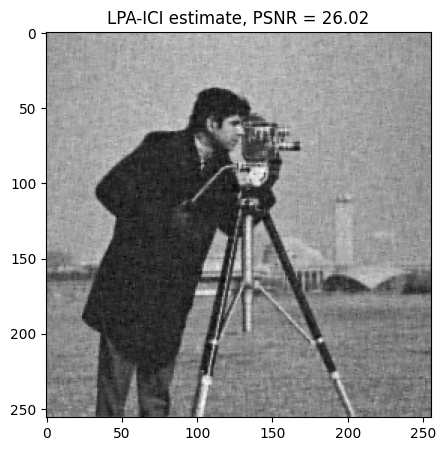

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(yhat, cmap='gray')
plt.title(f'LPA-ICI estimate, PSNR = {psnr:.2f}');